In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv
/kaggle/input/predicting-depression-machine-learning-challenge/train.csv
/kaggle/input/predicting-depression-machine-learning-challenge/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/train.csv')
test = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/test.csv')

submission = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/sample_submission.csv')


In [4]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Fill missing values
for col in ["Degree", "Financial Stress", "Dietary Habits"]:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(train[col].mode()[0], inplace=True)

for col in ["Work Pressure", "Job Satisfaction"]:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)

train["Profession"].fillna("Unknown", inplace=True)
test["Profession"].fillna("Unknown", inplace=True)

# Encode categorical columns
categorical_columns = ['Gender', 'Working Professional or Student','Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])  
    label_encoders[col] = le 

<ipython-input-4-1519b7eb10b4>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
<ipython-input-4-1519b7eb10b4>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [5]:
education_map = {
    "High School": ["Class 11", "Class 12"],
    
    "Diploma": [
        "B.Ed", "B.P.Ed", "L.Ed", "LCA", "RCA", "HCA", "N.Pharm", "S.Pharm", 
        "A.Ed", "E.Ed", "I.Ed", "J.Ed", "G.Ed", "K.Ed", "M.B.Ed", "M.M.Ed"
    ],
    
    "Bachelor's": [
        "B.Tech", "BE", "BSc", "B.Sc", "B.Arch", "B.B.Arch", "BBA", "B.Com", "B.Ed", "BCA",
        "B.Pharm", "BPharm", "BPA", "BHM", "B Student", "BArch", "BTech", "B.Com", "B.H", 
        "B.CA", "B.BA", "B.BCA", "B.Press", "B.B.Tech", "B.M.Com", "B.Financial Analyst"
    ],
    
    "Master's": [
        "M.Tech", "M_Tech", "MTech", "ME", "MSc", "MBA", "M.Com", "M.Ed", "MPharm", 
        "M.Pharm", "MPA", "MHM", "M.Arch", "M.S", "M. Business Analyst", "MA", "MCA", 
        "M.UI", "M.", "M.M.Ed"
    ],
    
    "Doctorate": ["PhD", "MD", "MBBS"],
    
    "Law": ["LLB", "LLBA", "LLM", "LL.Com", "LLCom", "LL B.Ed", "LLS", "LLEd"],
    
    "Other": [
        "Plumber", "Entrepreneur", "Working Professional", "Data Scientist", "HR Manager",
        "UX/UI Designer", "Business Analyst", "Doctor", "Mechanical Engineer", "Travel Consultant"
    ]
}

def map_education(value):
    for category, degrees in education_map.items():
        if value in degrees:
            return category
    return "Unknown"

train["Degree_new"] = train["Degree"].apply(map_education)
test["Degree_new"] = test["Degree"].apply(map_education)

In [6]:
def categorize(value):
    # Time-related categories
    short_duration = ['Less than 5 hours', '1-2 hours', '1-3 hours', '3-4 hours', '4-5 hours', '4-6 hours', '2-3 hours', '3-6 hours', '6 hours']
    medium_duration = ['than 5 hours','6-7 hours', '7-8 hours', '6-8 hours', '8 hours','More than 8 hours','8-9 hours','9-10 hours','9-11 hours','10-11 hours']
    long_duration = [ '9-5 hours', '9-6 hours', '10-6 hours', '20-21 hours', '60-65 hours', '50-75 hours', '40-45 hours', '45-48 hours', '55-66 hours', '45 hours', '49 hours']
    
    # Special situations
    special_situations = ['Unhealthy', 'Have_you_ever_had_suicidal_thoughts', 'Work_Study_Hours', 'Sleep_Duration', 'Vivan', 'No']
    
    # Location/Event
    location_event = ['Meerut', 'Pune', 'Indore', '9-5']
    
    # Miscellaneous categories
    ambiguous = ['0', '8-89 hours', 'Galesabad']

    if value in short_duration:
        return 'Short Duration'
    elif value in medium_duration:
        return 'Medium Duration'
    elif value in long_duration:
        return 'Long Duration'
    elif value in special_situations:
        return 'Special Situations'
    elif value in location_event:
        return 'Location/Event'
    elif value in ambiguous:
        return 'Miscellaneous'
    else:
        return 'Unknown'

# Example usage
train['Sleep Duration_new'] = train['Sleep Duration'].apply(categorize)
test['Sleep Duration_new'] = test['Sleep Duration'].apply(categorize)


In [7]:
#health_status = ['Healthy', 'Unhealthy', 'Moderate', 'More Healthy', 'No Healthy', 'Less Healthy', '5 Healthy', '5 Unhealthy', 'Resistant']
Good_Health=['Healthy','More Healthy', '5 Healthy']
Bad_Health=['Unhealthy','No Healthy','Less Healthy','5 Unhealthy']
Moderate_Health=['Moderate','Resistant']
other = ['BSc', 'Class 12', 'Academic', 'MCA','Gender', 'Yes', 'Mealy','Indoor', 'Electrician', 'MCA', 'Mealy', 'Hormonal', 'Vegas', 'Male', 'Soham', 'Pratham', 'Vivaan', 'Raghav', 'Naina', 'Kolkata']

# Function to classify values
def classify(value):
    if value in Good_Health:
        return 'Good_Health'
    elif value in Bad_Health:
        return 'Bad_Health'
    elif value in Moderate_Health:
        return 'Moderate_Health'
    elif value in other:
        return 'Other'
    else:
        return 'Uncategorized'

# Apply classification
train['Dietary_Habits_new'] = train['Dietary Habits'].apply(classify)
test['Dietary_Habits_new'] = test['Dietary Habits'].apply(classify)

In [8]:
train["new_col"] = train["Work Pressure"] + train["Job Satisfaction"]

In [9]:
df =  pd.concat([train, test], axis =0)

In [10]:
#train["new_col"] = train["Work Pressure"] + train["Job Satisfaction"]

#df =  pd.concat([train, test], axis =0)

#from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

label_encoders = {}
#for col in ['City','City_new', 'Dietary Habits','Dietary_Habits_new','Sleep Duration_new','Sleep Duration','Profession','Degree']:
for col in ['Sleep Duration_new','Dietary_Habits_new']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

def one_hot_encode_and_add(train, column):
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = one_hot_encoder.fit_transform(train[[column]])
    encoded_columns = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out([column]))
    encoded_columns.index = train.index
    train = pd.concat([train, encoded_columns], axis=1)
    train = train.drop(columns=[column])
    return train

#columns_to_encode = ['Profession_new', 'Degree_new','In_A_City']
columns_to_encode = ['Degree_new']

for col in columns_to_encode:
    df = one_hot_encode_and_add(df, col)


In [11]:
train = df.dropna(subset=['new_col'])
test = df[df['new_col'].isna()]

test = test.drop(columns=['new_col'])
train = train.drop(columns=['new_col'])
test = test.drop(columns=['Depression'])

In [12]:
test

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,...,Sleep Duration_new,Dietary_Habits_new,Degree_new_Bachelor's,Degree_new_Diploma,Degree_new_Doctorate,Degree_new_High School,Degree_new_Law,Degree_new_Master's,Degree_new_Other,Degree_new_Unknown
0,140700,Shivam,1,53.0,Visakhapatnam,1,Judge,NaN,2.0,NaN,...,4,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,140701,Sanya,0,58.0,Kolkata,1,Educational Consultant,NaN,2.0,NaN,...,4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140702,Yash,1,53.0,Jaipur,1,Teacher,NaN,4.0,NaN,...,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,140703,Nalini,0,23.0,Rajkot,0,Unknown,5.0,3.0,6.84,...,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,140704,Shaurya,1,47.0,Kalyan,1,Teacher,NaN,5.0,NaN,...,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,234495,Zoya,0,49.0,Jaipur,1,Pilot,NaN,3.0,NaN,...,4,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93796,234496,Shlok,1,29.0,Ahmedabad,1,Pilot,NaN,5.0,NaN,...,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93797,234497,Rishi,1,24.0,Visakhapatnam,0,Unknown,1.0,3.0,7.51,...,2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93798,234498,Eshita,0,23.0,Kalyan,1,Marketing Manager,NaN,4.0,NaN,...,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
 
# Define target variable (change 'target_column' to the actual target name)
target = "Depression"

# Define feature columns (exclude target column)
features = [col for col in train.columns if col != target]

# Identify categorical columns
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical columns to string (CatBoost prefers them as strings)
train[categorical_features] = train[categorical_features].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.2, random_state=42
)

train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features)


In [14]:
train.columns

Index(['id', 'Name', 'Gender', 'Age', 'City',
       'Working Professional or Student', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression',
       'Sleep Duration_new', 'Dietary_Habits_new', 'Degree_new_Bachelor's',
       'Degree_new_Diploma', 'Degree_new_Doctorate', 'Degree_new_High School',
       'Degree_new_Law', 'Degree_new_Master's', 'Degree_new_Other',
       'Degree_new_Unknown'],
      dtype='object')

In [15]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

In [16]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import shap
import numpy as np
import pandas as pd

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.2, random_state=42
)

# Define categorical features (Ensure it's a list of categorical column names)
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Initialize Stratified K-Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Perform cross-validation manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Convert to CatBoost Pool
    train_pool = Pool(X_train_fold, label=y_train_fold, cat_features=categorical_features)
    val_pool = Pool(X_val_fold, label=y_val_fold, cat_features=categorical_features)

    # Define the model
    model = CatBoostClassifier(
        iterations=500, learning_rate=0.05, max_depth=8, verbose=0
    )

    # Train model with early stopping
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)

    # Predict on validation set
    y_val_pred = model.predict(X_val_fold)
    
    # Compute accuracy
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_scores.append(accuracy)

    print(f"Fold {fold}: Accuracy = {accuracy:.4f}")

# Print cross-validation accuracy results
print(f"\nMean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train final model on full dataset
train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)
final_model = CatBoostClassifier( iterations=500, eval_metric='AUC',
    learning_rate=0.05, max_depth=8, verbose=100
)
final_model.fit(train_pool)

# Compute SHAP values for feature selection
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_train)

# Compute mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Convert to DataFrame
shap_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP_Value': shap_importance})

# Sort features by importance
shap_df = shap_df.sort_values(by='SHAP_Value', ascending=False)
print("\nSHAP Feature Importance:")
print(shap_df)

# Drop low-impact features (threshold can be adjusted)
threshold = shap_df['SHAP_Value'].quantile(0.1)  # Drop bottom 25% least impactful features
low_impact_features = shap_df[shap_df['SHAP_Value'] < threshold]['Feature'].tolist()
print(f"\nDropping {len(low_impact_features)} low-impact features: {low_impact_features}")

# Retrain with selected features
X_train_selected = X_train.drop(columns=low_impact_features)
X_test_selected = X_test.drop(columns=low_impact_features)

# Update categorical features list
categorical_features_selected = [f for f in categorical_features if f not in low_impact_features]

# Train final model after feature selection
train_pool_selected = Pool(X_train_selected, label=y_train, cat_features=categorical_features_selected)
final_model_selected = CatBoostClassifier(iterations=500, eval_metric='AUC',
    learning_rate=0.05, max_depth=8, verbose=100
)
final_model_selected.fit(train_pool_selected)

# Predict on test set
y_pred = final_model_selected.predict(X_test_selected)

# Compute final accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy after Feature Selection: {accuracy:.4f}")


0:	learn: 0.6078023	test: 0.6078331	best: 0.6078331 (0)	total: 194ms	remaining: 1m 36s
100:	learn: 0.1464747	test: 0.1496044	best: 0.1496044 (100)	total: 11.8s	remaining: 46.8s
200:	learn: 0.1386370	test: 0.1475470	best: 0.1475470 (200)	total: 23.6s	remaining: 35.1s
300:	learn: 0.1323530	test: 0.1470419	best: 0.1470406 (299)	total: 34.7s	remaining: 23s
400:	learn: 0.1267398	test: 0.1468682	best: 0.1468167 (362)	total: 45.9s	remaining: 11.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1468166697
bestIteration = 362

Shrink model to first 363 iterations.
Fold 1: Accuracy = 0.9407
0:	learn: 0.6075324	test: 0.6076379	best: 0.6076379 (0)	total: 117ms	remaining: 58.2s
100:	learn: 0.1449697	test: 0.1556027	best: 0.1556027 (100)	total: 12.4s	remaining: 49.1s
200:	learn: 0.1372766	test: 0.1538637	best: 0.1538637 (200)	total: 23.6s	remaining: 35.1s
300:	learn: 0.1312470	test: 0.1530585	best: 0.1530368 (298)	total: 35.4s	remaining: 23.4s
400:	learn: 0.1257440	test: 0.15279

In [17]:
# Drop low-impact features from test set
X_test_selected = test.drop(columns=low_impact_features)

# Handle missing values in categorical features
X_test_selected[categorical_features_selected] = X_test_selected[categorical_features_selected].fillna("Unknown")

# Ensure categorical features are of type string
X_test_selected[categorical_features_selected] = X_test_selected[categorical_features_selected].astype(str)

# Make predictions using the trained model
predictions = final_model_selected.predict(X_test_selected)

print("\nPredictions on test set completed!")



Predictions on test set completed!


In [18]:
predictions

array([0., 0., 0., ..., 0., 1., 0.])

In [19]:
predictions.shape

(93800,)

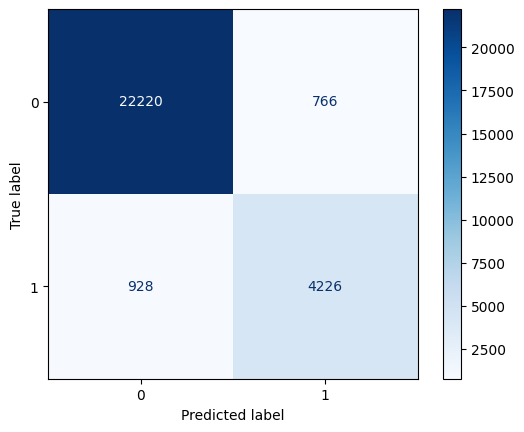

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Blues')
#cm_display.plot()


In [21]:
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0
...,...,...
93795,234495,0
93796,234496,0
93797,234497,0
93798,234498,0


In [22]:
submission["Depression"] = predictions.astype(int)

In [23]:
submission

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


In [24]:
submission["Depression"].value_counts()

Depression
0    77079
1    16721
Name: count, dtype: int64

In [25]:
submission.to_csv("Submission_63.csv",index=False)